# Import libraries

In [66]:
import numpy as np
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time


%matplotlib inline

In [67]:
# Check presence of GPU
is_gpu_avalaible = torch.cuda.is_available()
print(is_gpu_avalaible)

False


# Load the dataset

In [68]:
data = "dataset/eczema/"

train_dir = os.path.join(data, "train/")
test_dir = os.path.join(data, "test/")
val_dir = os.path.join(data, "val/")

In [69]:
classes = ["Atopic dermatitis", "Contact dermatitis", "Dyshidrotic eczema","Hand eczema","Neurodermatitis","Nummular eczema","Stasis dermatitis"]

# Transform the dataset

In [89]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [91]:
data_dir = data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [92]:
# data_transformer = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])

In [93]:
# train_data = datasets.ImageFolder(train_dir, transform=data_transformer)
# val_data = datasets.ImageFolder(val_dir, transform=data_transformer)
# # test_data = datasets.ImageFolder(test_dir, transform=data_transformer)

In [95]:
# print(f"Training image number is {len(train_data)}")
# print(f"Test image number is {len(test_data)}")
# print(f"Validation image number is {len(val_data)}")

# Load image into torch dataloader

In [96]:
#Const
batch_size = 32
num_workers = 0

In [97]:
train_loader = DataLoader(train_data, batch_size=batch_size,  num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

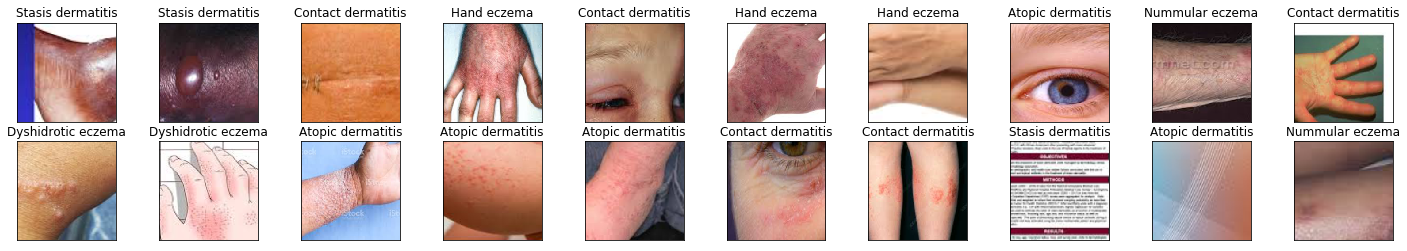

In [98]:
img, lables = iter(train_loader).next()
img = img.numpy()
# plt.imshow(img)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img[idx], (1, 2, 0)))
    ax.set_title(classes[lables[idx]])

In [99]:
# Model slection
resnet_50 = models.resnet50(pretrained=True)
# print(resnet_50)

In [100]:
print(resnet_50.fc.in_features)
print(resnet_50.fc.out_features)

2048
1000


In [101]:
# freezing the feature layers
for weights in resnet_50.parameters():
    weights.requires_grad = False

In [102]:
# updating the last fully connected layer
num_inputs = resnet_50.fc.in_features

# add linear layers with new number of classes
resnet_50.fc = nn.Linear(num_inputs, len(classes))

# add the model to gpu
if(is_gpu_avalaible):
    resnet_50.cuda()

## Verify that the number output changeto the len of the class
print(f"The new output size is: {resnet_50.fc.out_features}")

The new output size is: 7


## Loss function and Optimzer

In [107]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [108]:
criterion = nn.CrossEntropyLoss() # loss function
optimzer = optim.SGD(resnet_50.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimzer, step_size=7, gamma=0.1)

## Training

In [ ]:
resnet_50 = train_model(resnet_50, criterion, optimzer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.9236 Acc: 0.1958
val Loss: 1.8492 Acc: 0.2689

Epoch 1/24
----------
